In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, roc_curve, 
    precision_recall_fscore_support, plot_roc_curve, roc_auc_score
)

import plotly.express as px

from svm_utils import *
from feature_extraction import *

In [2]:
data_dir = '../../data'
pxm = 'p6m'
start_date = '2021/01/01'
end_date = '2021/06/30'

In [222]:
df_reg = pd.read_csv(os.path.join(data_dir, 'model/{}/full.csv'.format(pxm)))
train = pd.read_csv(os.path.join(data_dir, 'model/{}/train.csv'.format(pxm)))
val = pd.read_csv(os.path.join(data_dir, 'model/{}/validate.csv'.format(pxm)))
test = pd.read_csv(os.path.join(data_dir, 'model/{}/test.csv'.format(pxm)))
test = test.append(val)

train_idxs = [np.where(df_reg['id'] == cid)[0][0] for cid in train['id']]
test_idxs = [np.where(df_reg['id'] == cid)[0][0] for cid in test['id']]

# Transactions 

In [4]:
df_main = {}

In [5]:
fname = os.path.join(data_dir, 'main/currentacct_txn.csv')
df_trans = read_current(fname, df_reg['id'])
df_trans = summarise_id_day(df_trans, df_reg['id'], start_date, end_date)
df_main['current'] = df_trans

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
fname = os.path.join(data_dir, 'main/creditcard_txn.csv')
df_trans = read_credit(fname, df_reg['id'])
df_trans = summarise_id_day(df_trans, df_reg['id'], start_date, end_date)
df_main['credit'] = df_trans

In [7]:
fname = os.path.join(data_dir, 'main/savingacct_txn.csv')
df_trans = read_saving(fname, df_reg['id'])
df_trans = summarise_id_day(df_trans, df_reg['id'], start_date, end_date)
df_main['saving'] = df_trans

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


### Feature extraction

Param tuning

In [58]:
for acc_type in ['saving', 'current', 'credit']:
    
    df_trans = df_main[acc_type]
    
    for rolling_window in [7, 14, 21, 28]:

        cache_dir = 'rolled_cache/{}'.format(acc_type)
        dict_rolled = roll_df_cache(df_trans, df_reg['id'], rolling_window, cache_dir)


        df_rolled_full = pd.concat(list(dict_rolled.values()))
        df_rolled_full = np.log(df_rolled_full.replace({0: 1}))

        # rolled diff
        df_rolled_diff = pd.concat(list(dict_rolled.values()))
        df_rolled_diff = get_diff(df_rolled_diff)
        df_rolled_diff = np.log(df_rolled_diff.replace({0: 1}))


        for selected in ['diff', 'transact']:

            selected_c = selected + '_c'
            selected_d = selected + '_d'
            selected_full_df = df_rolled_full if selected == 'transact' else df_rolled_diff
            selected_feat_extractor = get_X_amount if selected == 'transact' else get_X_diff

            y = df_reg['is_affluent_cur']

            for nbins in [30, 40, 50, 60]:

                bins = {
                    selected_c: np.linspace(
                        selected_full_df[selected_c].min(), 
                        selected_full_df[selected_c].max(), 
                        nbins
                    ),
                    selected_d: np.linspace(
                        selected_full_df[selected_d].min(), 
                        selected_full_df[selected_d].max(), 
                        nbins
                    )
                }

                X, meta = selected_feat_extractor(dict_rolled, df_reg['id'], bins)

                # remove features with all 0s
                X = X[:, X.sum(axis=0) > 10]

                X_train, y_train = split_by_idxs(X, y, train_idxs)

                # cross validation
                scores = []
                skf = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
                for train_index, test_index in skf.split(X_train, y_train):
                    svm = get_svm_classifier()
                    svm.fit(X_train[train_index, :], y_train[train_index])
                    pred_probs = svm.predict_proba(X_train[test_index, :])
                    score = roc_auc_score(y_train[test_index], pred_probs[:, 1])
                    scores.append(score)
                scores = np.array(scores)
                print(acc_type, rolling_window, selected, nbins, scores.round(2), round(scores.mean(), 4))

  0%|          | 0/6049 [00:00<?, ?it/s]

saving 7 diff 30 [0.65 0.66 0.63] 0.6482
saving 7 diff 40 [0.63 0.63 0.62] 0.6282
saving 7 diff 50 [0.62 0.61 0.62] 0.617
saving 7 diff 60 [0.66 0.63 0.67] 0.6563
saving 7 transact 30 [0.62 0.7  0.62] 0.6453
saving 7 transact 40 [0.59 0.63 0.57] 0.5963
saving 7 transact 50 [0.66 0.67 0.65] 0.6573
saving 7 transact 60 [0.64 0.67 0.65] 0.6536


  0%|          | 0/6049 [00:00<?, ?it/s]

saving 14 diff 30 [0.69 0.65 0.59] 0.641
saving 14 diff 40 [0.7  0.64 0.64] 0.6593
saving 14 diff 50 [0.63 0.6  0.6 ] 0.6097
saving 14 diff 60 [0.62 0.61 0.64] 0.6201
saving 14 transact 30 [0.64 0.73 0.65] 0.6759
saving 14 transact 40 [0.59 0.66 0.59] 0.6108
saving 14 transact 50 [0.68 0.71 0.63] 0.6721
saving 14 transact 60 [0.66 0.69 0.64] 0.6624


  0%|          | 0/6049 [00:00<?, ?it/s]

saving 21 diff 30 [0.66 0.62 0.66] 0.649
saving 21 diff 40 [0.63 0.64 0.63] 0.633
saving 21 diff 50 [0.65 0.64 0.62] 0.637
saving 21 diff 60 [0.6  0.63 0.65] 0.6244
saving 21 transact 30 [0.64 0.67 0.65] 0.6531
saving 21 transact 40 [0.61 0.73 0.6 ] 0.6472
saving 21 transact 50 [0.66 0.69 0.63] 0.6596
saving 21 transact 60 [0.62 0.67 0.65] 0.6496


  0%|          | 0/6049 [00:00<?, ?it/s]

saving 28 diff 30 [0.57 0.6  0.63] 0.603
saving 28 diff 40 [0.59 0.61 0.65] 0.6181
saving 28 diff 50 [0.6  0.63 0.71] 0.6451
saving 28 diff 60 [0.66 0.67 0.72] 0.6832
saving 28 transact 30 [0.61 0.65 0.63] 0.6305
saving 28 transact 40 [0.56 0.71 0.61] 0.6243
saving 28 transact 50 [0.6  0.68 0.61] 0.6296
saving 28 transact 60 [0.61 0.63 0.59] 0.6111


  0%|          | 0/6049 [00:00<?, ?it/s]

current 7 diff 30 [0.55 0.55 0.62] 0.572
current 7 diff 40 [0.53 0.58 0.59] 0.564
current 7 diff 50 [0.57 0.54 0.61] 0.5723
current 7 diff 60 [0.57 0.57 0.58] 0.5734
current 7 transact 30 [0.57 0.54 0.67] 0.5936
current 7 transact 40 [0.57 0.56 0.3 ] 0.4768
current 7 transact 50 [0.55 0.56 0.69] 0.602
current 7 transact 60 [0.58 0.59 0.63] 0.5975


  0%|          | 0/6049 [00:00<?, ?it/s]

current 14 diff 30 [0.54 0.55 0.61] 0.5655
current 14 diff 40 [0.53 0.62 0.55] 0.5678
current 14 diff 50 [0.53 0.6  0.64] 0.5875
current 14 diff 60 [0.52 0.6  0.63] 0.5832
current 14 transact 30 [0.52 0.52 0.48] 0.5101
current 14 transact 40 [0.59 0.61 0.63] 0.6084
current 14 transact 50 [0.58 0.55 0.65] 0.5955
current 14 transact 60 [0.58 0.61 0.62] 0.5995


  0%|          | 0/6049 [00:00<?, ?it/s]

current 21 diff 30 [0.55 0.56 0.49] 0.5308
current 21 diff 40 [0.53 0.54 0.58] 0.5489
current 21 diff 50 [0.52 0.6  0.57] 0.5645
current 21 diff 60 [0.52 0.6  0.57] 0.5629
current 21 transact 30 [0.57 0.57 0.54] 0.5603
current 21 transact 40 [0.58 0.54 0.6 ] 0.573
current 21 transact 50 [0.59 0.52 0.59] 0.5659
current 21 transact 60 [0.58 0.61 0.59] 0.5929


  0%|          | 0/6049 [00:00<?, ?it/s]

current 28 diff 30 [0.58 0.6  0.53] 0.5684
current 28 diff 40 [0.51 0.61 0.52] 0.546
current 28 diff 50 [0.53 0.57 0.6 ] 0.5655
current 28 diff 60 [0.52 0.54 0.54] 0.5365
current 28 transact 30 [0.58 0.58 0.58] 0.5797
current 28 transact 40 [0.56 0.54 0.6 ] 0.5666
current 28 transact 50 [0.56 0.53 0.59] 0.56
current 28 transact 60 [0.56 0.61 0.56] 0.5743


  0%|          | 0/6049 [00:00<?, ?it/s]

credit 7 diff 30 [0.47 0.49 0.55] 0.5016
credit 7 diff 40 [0.47 0.5  0.51] 0.4935
credit 7 diff 50 [0.52 0.39 0.5 ] 0.4702
credit 7 diff 60 [0.5  0.45 0.54] 0.4953
credit 7 transact 30 [0.62 0.53 0.43] 0.5251
credit 7 transact 40 [0.38 0.47 0.46] 0.4379
credit 7 transact 50 [0.39 0.45 0.49] 0.4464
credit 7 transact 60 [0.46 0.54 0.52] 0.5041


  0%|          | 0/6049 [00:00<?, ?it/s]

credit 14 diff 30 [0.52 0.46 0.53] 0.5053
credit 14 diff 40 [0.49 0.47 0.43] 0.4635
credit 14 diff 50 [0.49 0.5  0.6 ] 0.5277
credit 14 diff 60 [0.45 0.47 0.45] 0.4555
credit 14 transact 30 [0.5  0.46 0.48] 0.4811
credit 14 transact 40 [0.44 0.48 0.56] 0.495
credit 14 transact 50 [0.49 0.52 0.42] 0.4744
credit 14 transact 60 [0.47 0.54 0.54] 0.5156


  0%|          | 0/6049 [00:00<?, ?it/s]

credit 21 diff 30 [0.41 0.44 0.48] 0.4429
credit 21 diff 40 [0.46 0.44 0.4 ] 0.4334
credit 21 diff 50 [0.44 0.45 0.53] 0.4724
credit 21 diff 60 [0.37 0.43 0.49] 0.4323
credit 21 transact 30 [0.41 0.52 0.52] 0.4847
credit 21 transact 40 [0.45 0.5  0.6 ] 0.5166
credit 21 transact 50 [0.5  0.51 0.44] 0.4855
credit 21 transact 60 [0.51 0.55 0.6 ] 0.554


  0%|          | 0/6049 [00:00<?, ?it/s]

credit 28 diff 30 [0.54 0.42 0.49] 0.4852
credit 28 diff 40 [0.56 0.39 0.46] 0.4718
credit 28 diff 50 [0.44 0.44 0.46] 0.4441
credit 28 diff 60 [0.57 0.42 0.43] 0.47
credit 28 transact 30 [0.45 0.54 0.44] 0.4775
credit 28 transact 40 [0.54 0.49 0.63] 0.5513
credit 28 transact 50 [0.54 0.48 0.62] 0.5474
credit 28 transact 60 [0.47 0.5  0.56] 0.51


Visualisation

In [310]:
# selected = 'transact'
selected = 'diff'
selected_c = selected + '_c'
selected_d = selected + '_d'

nbins = 30

if selected == 'diff':
    bins = {
        'diff_c': np.linspace(
            df_rolled_diff['diff_c'].min(), 
            df_rolled_diff['diff_c'].max(), 
            nbins
        ),
        'diff_d': np.linspace(
            df_rolled_diff['diff_d'].min(), 
            df_rolled_diff['diff_d'].max(), 
            nbins
        )
    }
    X, meta = get_X_diff(dict_rolled, df_reg['id'], bins)
else:
    bins = {
        'transact_c': np.linspace(
            df_rolled_full['transact_c'].min(), 
            df_rolled_full['transact_c'].max(), 
            nbins
        ),
        'transact_d': np.linspace(
            df_rolled_full['transact_d'].min(), 
            df_rolled_full['transact_d'].max(), 
            nbins
        )
    }
    X, meta = get_X_amount(dict_rolled, df_reg['id'], bins)
X[:, X.sum(axis=0).argsort()[-2:]] = 0
y = df_reg['is_affluent_cur']
plot_features(X, meta, y)

In [312]:
# tidy to demo df

colnames = []
for col, n in meta:
    for i in range(n):
        colnames.append(col + str(i))

df_X = pd.DataFrame(X)
df_X.columns = colnames
df_X['y'] = y
df_X = df_X.melt('y', colnames, var_name='transact')
df_X['type'] = df_X['transact'].str.extract('([a-zA-Z_]+)')
df_X['transact'] = df_X['transact'].str.extract('([0-9]+)').astype(int)
df_X_avg = df_X.groupby(['type', 'y', 'transact']).mean()
df_X_avg = df_X_avg.reset_index(drop=False)
df_X_avg['y'] = df_X_avg['y'].replace({1: 'Affluent', 0: 'Non-Affluent'})
for colname in [selected_c, selected_d]:
    df_X_avg.loc[df_X_avg['type'] == colname, 'transact'] = bins[colname][df_X_avg.loc[df_X_avg['type'] == colname, 'transact'].astype(int)]
df_X_avg['transact'] = np.exp(df_X_avg['transact'])
df_X_avg['value'] = df_X_avg['value'].round(2)
df_X_avg['transact'] = df_X_avg['transact'].round(2)
df_X_avg['type'] = df_X_avg['type'].replace({selected_c: 'credit', selected_d: 'debit'})
df_X_avg = df_X_avg.rename(
    {
        'value': 'Frequency', 
        'y': 'Segment after 6 months', 
        'transact': 'Transaction Amount' if selected == 'transact' else 'First Difference',
        'type': 'Type'
    }, 
    axis=1
)

# path = os.path.join(data_dir, 'demo', acc_type, 'summ_diff.csv' if selected == 'diff' else 'summ_amount.csv')
# df_X_avg.to_csv(path, index=False)

In [313]:
# vis
tmp = df_X_avg[df_X_avg['Type'] == 'credit']
xlab = 'Transaction Amount' if selected == 'transact' else 'First Difference'
fig = px.line(tmp, x=xlab, y="Frequency", color='Segment after 6 months', line_shape='spline', log_x=True)
fig.update_layout(
		margin=dict(l=0, r=0, t=0, b=0),
		paper_bgcolor='rgba(0,0,0,0)',
		plot_bgcolor='rgba(0,0,0,0)',
		legend=dict(
		    orientation="h",
		    yanchor="bottom",
		    y=1.02,
		    xanchor="left",
		    x=0
		)
	)
fig.show()

### Modelling (SVM)

In [298]:
# params
acc_type = 'credit'
rolling_window = 14

# retrieve dfs
df_trans = df_main[acc_type]
cache_dir = 'rolled_cache/{}'.format(acc_type)
dict_rolled = roll_df_cache(df_trans, df_reg['id'], rolling_window, cache_dir)

# for min max
df_rolled_full = pd.concat(list(dict_rolled.values()))
df_rolled_full = np.log(df_rolled_full.replace({0: 1}))
df_rolled_diff = pd.concat(list(dict_rolled.values()))
df_rolled_diff = get_diff(df_rolled_diff)
df_rolled_diff = np.log(df_rolled_diff.replace({0: 1}))

  0%|          | 0/6049 [00:00<?, ?it/s]

In [303]:
selected = 'transact'
nbins = 45

selected_c = selected + '_c'
selected_d = selected + '_d'
selected_full_df = df_rolled_full if selected == 'transact' else df_rolled_diff
selected_feat_extractor = get_X_amount if selected == 'transact' else get_X_diff



bins = {
    selected_c: np.linspace(
        selected_full_df[selected_c].min(), 
        selected_full_df[selected_c].max(), 
        nbins
    ),
    selected_d: np.linspace(
        selected_full_df[selected_d].min(), 
        selected_full_df[selected_d].max(), 
        nbins
    )
}

X, meta = selected_feat_extractor(dict_rolled, df_reg['id'], bins)


# remove features with all 0s
X = X[:, X.sum(axis=0) > 10]

y = df_reg['is_affluent_cur']
X_train, y_train = split_by_idxs(X, y, train_idxs)
X_test, y_test = split_by_idxs(X, y, test_idxs)

svm = get_svm_classifier()
svm.fit(X_train, y_train)
pred_probs = svm.predict_proba(X_test)
auc = roc_auc_score(y_test, pred_probs[:, 1])

print(auc)

0.5953984370374755


In [304]:
# pred = (pred_probs[:, 0] < 0.574).astype(int)

# precision, recall, f1, _ = precision_recall_fscore_support(y_test, pred, average='binary', pos_label=1)
# print(np.array([precision, recall, f1]).round(4))
# confusion_matrix(pred, y_test)

0.5953984370374755

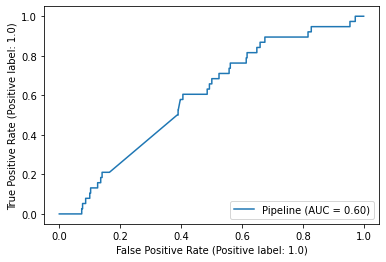

In [305]:
plot_roc_curve(svm, X_test, y_test)
roc_auc_score(y_test, pred_probs[:, 1])

In [306]:
df_feat = pd.DataFrame(X)
df_feat.columns = ['X_' + str(i) for i in df_feat.columns]
df_feat['y'] = y
df_feat['id'] = df_reg['id']

df_probs = pd.DataFrame(pred_probs)
df_probs.columns = ['p0', 'p1']
df_probs['y'] = y_test
df_probs['id'] = df_reg.loc[test_idxs, 'id'].reset_index(drop=True)

df_feat.to_csv('data/features/{}_{}.csv'.format(acc_type, selected), index=False)
df_probs.to_csv('data/predictions/{}_{}.csv'.format(acc_type, selected), index=False)